In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erfc
import os

gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
    if(sn.__version__ != '0.15.1'):
        print("WARNING: Sionna version is not 0.15.1, but " + sn.__version__)
except ImportError as e:
    # Install Sionna if package is not already installed
    os.system("pip install sionna")
    import sionna as sn

print(sn.__version__)

# Import TensorFlow and NumPy
import tensorflow as tf
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    from google.colab import files
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass



0.16.1


## General parameters

In [102]:
Alamouti = True
Scenario = 0
Rendering = 0 #It might take time to rander the scenes ;)
#For the scenario SISO
Scenario11 = 0
Rendering11 = 0
global_viewing = 0
#For the scenario TX2 - RX1
Scenario21 = 0
Rendering21 = 0


Frames_spacing = 1/(15e3) #Rate at which the frames in the channel creation must be distant :-)
Moving_mode = 0 # 0 = static; 1 = moving fast; 2 = moving very fast

#################### Parameters ####################
num_bits_per_symbol = 2
batch_size = 1
num_streams_per_tx = 1
num_tx = 2
num_streams_per_rx = 1
num_rx = 2
num_ofdm_symbols = 2  # 10
fft_size = 76
subcarrier_spacing = 15e3
SNR = np.arange(0, 20 , 2)
OFDM_pilots_time = []
batch_size_channel = 1
####################################################

# Scenarios

## Scenario SISO

In [103]:
if(Scenario11):
  scene11 = load_scene(sn.rt.scene.munich)

  # Create new camera with different configuration
  my_cam11 = Camera("my_cam", position=[-250,250,150], look_at=[-15,75,28])

  scene11.add(my_cam11)
  # Render scene with new camera*
  if(Rendering11):
    scene11.render("my_cam", resolution=resolution, num_samples=512); # Increase num_samples to increase image quality

In [104]:
if(Scenario11):
  # Configure antenna array for all transmitters
  scene11.tx_array = PlanarArray(num_rows=1,
                              num_cols=1,
                              vertical_spacing=0.5,
                              horizontal_spacing=0.5,
                              pattern="tr38901",
                              polarization="V")

  # Configure antenna array for all receivers
  scene11.rx_array = PlanarArray(num_rows=1,
                              num_cols=1,
                              vertical_spacing=0.5,
                              horizontal_spacing=0.5,
                              pattern="dipole",
                              polarization="V")

  # Create transmitter
  tx1 = Transmitter(name="tx1",
                  position=[8.5,21,27])

  tx = [tx1]

  # Add transmitter instance to scene
  for i in range(len(tx)):
    scene11.add(tx[i])



  if(Scenario11):
    scene11.frequency = 1.8e9 # in Hz; implicitly updates RadioMaterials
    scene11.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [105]:
if(Scenario11):
  if(Moving_mode == 2):
    Frames_spacing = 0.3
    speed = [8*Frames_spacing,-3*Frames_spacing]  #m/iter
  if(Moving_mode == 1):
    speed = [8*Frames_spacing,-3*Frames_spacing]  #m/iter
  if(Moving_mode == 0):
    speed = [0,0]

  x_init_1 = [147.2, 87.3, 1.5]   #Point D
  '''
  x_init_1 = [90.2, 80.3, 1.5]   #Point C

  x_init_1 = [20.2, 82.3, 1.5]   # Point B

  x_init_1 = [20.2, 80.3, 1.5]   # Point A

  '''

    # Create a receiver
  num_iter = 1  # 10 before
  paths_array = []


  for j in range(num_iter):
    if(j != 0):
      for i in range(len(rx)):
        scene11.remove(rx[i].name)

    new_pos_1 = [x_init_1[0] + speed[0]*j , x_init_1[1] + speed[1]*j , x_init_1[2]]

    rx1 = Receiver(name="rx1",
                  position=new_pos_1,
                  orientation=[0,0,0])
    rx = [rx1]
    # Add receiver instance to scene
    for i in range(len(rx)):
      scene11.add(rx[i])
    for i in range(len(tx)):
      tx[i].look_at(rx[i]) # Transmitter points towards receiver (tx1 to rx1 and tx2 to rx2)


    # Compute propagation paths
    paths = scene11.compute_paths(max_depth=5,
                                method = "fibonacci")
    paths_array.append(paths)

    # Visualize paths in the 3D preview
    if(Rendering11):
      if colab_compat:
          scene11.render_to_file(camera="my_cam", paths=paths_array[-1], show_devices=True, show_paths=True,
                         filename="scene_at_time_"+str(j)+"bis.png",
                         resolution=resolution)

    print("iteration - ",j,"finished - new position is ", new_pos_1)

In [106]:
if(Scenario11):
  paths = paths_array[-1]
  #Channel delays for the paths
  a, tau = paths.cir()

  t = tau[0,0,0,:]/1e-9 # Scale to ns

  a_abs = np.abs(a)[0,0,0,0,0,:,0]

  a_max = np.max(a_abs)
  t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
  a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

  # And plot the CIR
  plt.figure()
  plt.title("Channel impulse response realization")

  plt.stem(t, a_abs)    #
  plt.xlim([0, np.max(t)])
  plt.ylim([-2e-6, a_max*1.1])
  plt.xlabel(r"$\tau$ [ns]")
  plt.ylabel(r"$|a|$");

In [107]:
if(Scenario11):
  frequencies = sn.channel.subcarrier_frequencies(fft_size, subcarrier_spacing)
  # Compute the frequency response of the channel at frequencies.
  h_freq = sn.channel.cir_to_ofdm_channel(frequencies,
                              a,
                              tau,
                              normalize=True)

  h_avg_power = tf.reduce_mean(tf.abs(h_freq)**2).numpy()

  print("Shape of h_freq: ", h_freq.shape)
  print("Average power h_freq: ", h_avg_power) # Channel is normalized

In [108]:
#We do the same but on multiple paths. For instance of the object is moving and we have multiple itération (over 1), we compute the channel for each iteration.
if(Scenario11):

  #definition of an array for the different frames of raytracing
  h_freq_array = []
  for i in range(len(paths_array)):
    a_temp, tau_temp  = paths_array[i].cir()
    t_temp = tau_temp[0,0,0,:]/1e-9 # Scale to ns

    a_abs_temp = np.abs(a_temp)[0,0,0,0,0,:,0]

    a_max_temp = np.max(a_abs_temp)
    t_temp = np.concatenate([(0.,), t_temp, (np.max(t)*1.1,)])
    a_abs_temp = np.concatenate([(np.nan,), a_abs_temp, (np.nan,)])

    frequencies = sn.channel.subcarrier_frequencies(fft_size, subcarrier_spacing)

    # Compute the frequency response of the channel at frequencies.
    h_freq_array.append(sn.channel.cir_to_ofdm_channel(frequencies,
                                a_temp,
                                tau_temp,
                                normalize=True))

    h_avg_power = tf.reduce_mean(tf.abs(h_freq_array[-1])**2).numpy()

    print("Shape of h_freq: ", h_freq_array[-1].shape)
    print("Average power h_freq: ", h_avg_power) # Channel is normalized


# #We write the matrix of the channel in a file in order to reuse it later and not to compute it multiple times
# file1 = open('myfile_11_D.txt', 'w')
# file1.write(str(h_freq_array))
# file1.close()

## Scenario TX2 - RX2

In [109]:
if(Scenario):
  scene = load_scene(sn.rt.scene.munich)
  # Create new camera with different configuration
  my_cam = Camera("my_cam", position=[-250,250,150], look_at=[-15,75,28])
  scene.add(my_cam)
  # Render scene with new camera*
  if(Rendering):
    scene.render("my_cam", resolution=resolution, num_samples=512); # Increase num_samples to increase image quality


In [110]:
if(Scenario):
  # Configure antenna array for all transmitters
  scene.tx_array = PlanarArray(num_rows=1,
                              num_cols=1,
                              vertical_spacing=0.5,
                              horizontal_spacing=0.5,
                              pattern="tr38901",
                              polarization="V")

  # Configure antenna array for all receivers
  scene.rx_array = PlanarArray(num_rows=1,
                              num_cols=1,
                              vertical_spacing=0.5,
                              horizontal_spacing=0.5,
                              pattern="dipole",
                              polarization="V")

  # Create transmitter
  tx1 = Transmitter(name="tx1",
                  position=[8.5,21,27])

  tx2 = Transmitter(name="tx2",
                  position=[10.5,21,27])

  tx = [tx1 , tx2]

  # Add transmitter instance to scene
  for i in range(len(tx)):
    scene.add(tx[i])



  if(Scenario):
    scene.frequency = 1.8e9 # in Hz;
    scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

#If global viewing is activated, we can see the whole scene with all the receivers and transmitters
  if(global_viewing):
    my_cam_global = Camera("my_cam_global", position=[10,80,350], look_at=[80,80,0])
    scene.add(my_cam_global)
    rxA = Receiver(name="A",
              position=[20.2, 80.3, 1.5],
              orientation=[0,0,0])
    rxB = Receiver(name="B",
          position=[20.7, 82.3, 1.5],
          orientation=[0,0,0])
    rxC = Receiver(name="C",
              position=[90.2, 80.3, 1.5],
              orientation=[0,0,0])
    rxD = Receiver(name="D",
          position=[147.2, 87.3, 1.5],
          orientation=[0,0,0])
    scene.add(rxA)
    scene.add(rxB)
    scene.add(rxC)
    scene.add(rxD)
    resolution = [1280,720]
    scene.render("my_cam_global", resolution=resolution, num_samples=512); # Increase num_samples to increase image quality
    scene.remove(rxA.name)
    scene.remove(rxB.name)
    scene.remove(rxC.name)
    scene.remove(rxD.name)

In [111]:
if(Scenario):
  if(Moving_mode == 2):
    Frames_spacing = 0.3
    speed = [8*Frames_spacing,-3*Frames_spacing]  #m/iter
  if(Moving_mode == 1):
    speed = [8*Frames_spacing,-3*Frames_spacing]  #m/iter
  if(Moving_mode == 0):
    speed = [0,0]

  '''
  x_init_1 = [147.2, 87.3, 1.5]   #Point D
  x_init_2 = [147.0, 87.3, 1.5]

  x_init_1 = [90.2, 80.3, 1.5]   #Point C
  x_init_2 = [90.0, 80.3, 1.5]

  x_init_1 = [20.2, 80.3, 1.5]   # Point A
  x_init_2 = [20.0, 80.3, 1.5]
  '''
  x_init_1 = [20.7, 82.3, 1.5]   # Point B
  x_init_2 = [20.5, 82.3, 1.5]


    # Create a receiver
  num_iter = 1
  paths_array = []


  for j in range(num_iter):
    if(j != 0):
      for i in range(len(rx)):
        scene.remove(rx[i].name)

    new_pos_1 = [x_init_1[0] + speed[0]*j , x_init_1[1] + speed[1]*j , x_init_1[2]]
    new_pos_2 = [x_init_2[0] + speed[0]*j , x_init_2[1] + speed[1]*j , x_init_2[2]]


    #print("RX Configuration")
    rx1 = Receiver(name="rx1",
                  position=new_pos_1,
                  orientation=[0,0,0])

    rx2 = Receiver(name="rx2",
                  position=new_pos_2,
                  orientation=[0,0,0])
    rx = [rx1 , rx2]
    # Add receiver instance to scene
    for i in range(len(rx)):
      scene.add(rx[i])

    for i in range(len(tx)):
      tx[i].look_at(rx[i]) # Transmitter points towards receiver (tx1 to rx1 and tx2 to rx2)


    # Compute propagation paths
    paths = scene.compute_paths(max_depth=5,
                                method = "fibonacci")
    paths_array.append(paths)

    if(Rendering):
      if colab_compat:
          scene.render_to_file(camera="my_cam", paths=paths_array[-1], show_devices=True, show_paths=True,
                         filename="scene_at_time_"+str(j)+"bis.png",
                         resolution=resolution)

    print("iteration - ",j,"finished - new position is ", new_pos_1)



In [112]:
if(Scenario):
  paths = paths_array[-1] #We take the last iteration of the paths (it number of iteration is 1, it is the only one)
  a, tau = paths.cir()
  print("Shape of tau: ", tau.shape)
  print("Shape of a: ",  a.shape)


  t = tau[0,0,0,:]/1e-9 # Scale to ns

  a_abs = np.abs(a)[0,0,0,0,0,:,0]

  a_max = np.max(a_abs)
  t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
  a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

  #Plot the CIR
  plt.figure()
  plt.title("Channel impulse response realization")

  plt.stem(t, a_abs)    #
  plt.xlim([0, np.max(t)])
  plt.ylim([-2e-6, a_max*1.1])
  plt.xlabel(r"$\tau$ [ns]")
  plt.ylabel(r"$|a|$");




In [113]:
if(Scenario):
  frequencies = sn.channel.subcarrier_frequencies(fft_size, subcarrier_spacing)
  # Compute the frequency response of the channel at frequencies.
  h_freq = sn.channel.cir_to_ofdm_channel(frequencies,
                              a,
                              tau,
                              normalize=True)

  h_avg_power = tf.reduce_mean(tf.abs(h_freq)**2).numpy()

  print("Shape of h_freq: ", h_freq.shape)
  print("Average power h_freq: ", h_avg_power) # Channel is normalized

## Creation of the multiple frames of raytracing into different channel

In [114]:
# We do the same but on multiple paths. For instance of the object is moving and we have multiple itération (over 1), we compute the channel for each iteration.
if(Scenario):

  #definition of an array for the different frames of raytracing
  h_freq_array = []
  for i in range(len(paths_array)):
    a_temp, tau_temp  = paths_array[i].cir()
    t_temp = tau_temp[0,0,0,:]/1e-9 # Scale to ns

    a_abs_temp = np.abs(a_temp)[0,0,0,0,0,:,0]

    a_max_temp = np.max(a_abs_temp)
    t_temp = np.concatenate([(0.,), t_temp, (np.max(t)*1.1,)])
    a_abs_temp = np.concatenate([(np.nan,), a_abs_temp, (np.nan,)])

    frequencies = sn.channel.subcarrier_frequencies(fft_size, subcarrier_spacing)

    # Compute the frequency response of the channel at frequencies.
    h_freq_array.append(sn.channel.cir_to_ofdm_channel(frequencies,
                                a_temp,
                                tau_temp,
                                normalize=True))

    h_avg_power = tf.reduce_mean(tf.abs(h_freq_array[-1])**2).numpy()

    print("Shape of h_freq: ", h_freq_array[-1].shape)
    print("Average power h_freq: ", h_avg_power) # Channel is normalized



## Scenario TX2 - RX1

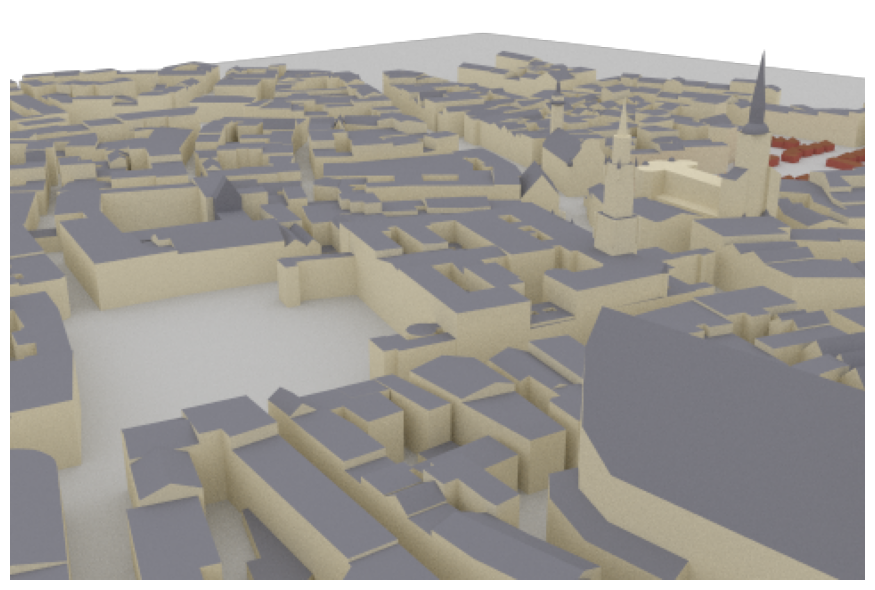

In [115]:
if(Scenario21):
  scene21 = load_scene(sn.rt.scene.munich)

  # Create new camera with different configuration
  my_cam21 = Camera("my_cam21", position=[-250,250,150], look_at=[-15,30,28])
  scene21.add(my_cam21)

  # Render scene with new camera*
  if(Rendering21):
    scene21.render("my_cam21", resolution=resolution, num_samples=512); # Increase num_samples to increase image quality

In [116]:
if(Scenario21):
  # Configure antenna array for all transmitters
  scene21.tx_array = PlanarArray(num_rows=1,
                              num_cols=1,
                              vertical_spacing=0.5,
                              horizontal_spacing=0.5,
                              pattern="tr38901",
                              polarization="V")

  # Configure antenna array for all receivers
  scene21.rx_array = PlanarArray(num_rows=1,
                              num_cols=1,
                              vertical_spacing=0.5,
                              horizontal_spacing=0.5,
                              pattern="dipole",
                              polarization="V")

  # Create transmitter
  tx1 = Transmitter(name="tx1",
                  position=[8.5,21,27])

  tx2 = Transmitter(name="tx2",
                  position=[10.5,21,27])

  tx21 = [tx1 , tx2]

  # Add transmitter instance to scene
  for i in range(len(tx21)):
    scene21.add(tx21[i])

In [117]:
if(Scenario21):
  scene21.frequency = 1.8e9 # in Hz; implicitly updates RadioMaterials
  scene21.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [118]:

if(Scenario21):
  if(Moving_mode == 2):
    Frames_spacing = 0.3
    speed = [8*Frames_spacing,-3*Frames_spacing]  #m/iter
  if(Moving_mode == 1):
    speed = [8*Frames_spacing,-3*Frames_spacing]  #m/iter
  if(Moving_mode == 0):
    speed = [0,0]

  x_init_1 = [147.2, 87.3, 1.5]

  '''
  x_init_1 = [20.7, 82.3, 1.5]    # point B
  #x_init_1 = [147.2, 87.3, 1.5]  # point D
  #x_init_1 = [90.2, 80.3, 1.5]   #Point C
  #x_init_1 = [20.2, 80.3, 1.5]   # Point A
  '''

  # Create a receiver
  num_iter = 1
  paths_array21 = []


  for j in range(num_iter):
    if(j != 0):
      for i in range(len(rx21)):
        scene21.remove(rx21[i].name)

    new_pos_1 = [x_init_1[0] + speed[0]*j , x_init_1[1] + speed[1]*j , x_init_1[2]]


    rx1 = Receiver(name="rx1",
                  position=new_pos_1,
                  orientation=[0,0,0])

    rx21 = [rx1]
    # Add receiver instance to scene
    for i in range(len(rx21)):
      scene21.add(rx21[i])

    for i in range(len(tx21)):
      tx21[i].look_at(rx21[0]) # Transmitter points towards receiver (tx1 to rx1 and tx2 to rx2)


    # Compute propagation paths
    paths21 = scene21.compute_paths(max_depth=5,
                                method = "fibonacci")
    paths_array21.append(paths21)

    # Visualize paths in the 3D preview
    if(Rendering):
      if colab_compat:
          scene.render_to_file(camera="my_cam21", paths=paths_array[-1], show_devices=True, show_paths=True,
                         filename="scene_at_time_"+str(j)+"_scenario_21.png",
                         resolution=resolution)
    print("iteration - ",j,"finished - new position is ", new_pos_1)



iteration -  0 finished - new position is  [147.2, 87.3, 1.5]


Shape of tau:  (1, 1, 2, 4)
Shape of a:  (1, 1, 1, 2, 1, 4, 1)


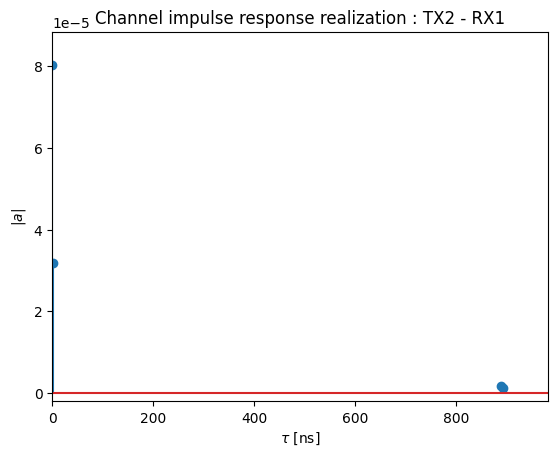

In [119]:
if(Scenario21):
  #Channel delays for the paths
  a21, tau21 = paths21.cir()
  print("Shape of tau: ", tau21.shape)
  print("Shape of a: ",  a21.shape)


  t21 = tau21[0,0,0,:]/1e-9 # Scale to ns

  a_abs21 = np.abs(a21)[0,0,0,0,0,:,0]

  a_max21 = np.max(a_abs21)
  t21 = np.concatenate([(0.,), t21, (np.max(t21)*1.1,)])
  a_abs21 = np.concatenate([(np.nan,), a_abs21, (np.nan,)])

  # And plot the CIR
  plt.figure()
  plt.title("Channel impulse response realization : TX2 - RX1")

  plt.stem(t21, a_abs21)    #
  plt.xlim([0, np.max(t21)])
  plt.ylim([-2e-6, a_max21*1.1])
  plt.xlabel(r"$\tau$ [ns]")
  plt.ylabel(r"$|a|$");

In [120]:
if(Scenario21):
  fft_size21 = 76
  subcarrier_spacing21 = 15e3
  frequencies21 = sn.channel.subcarrier_frequencies(fft_size21, subcarrier_spacing21)

  # Compute the frequency response of the channel at frequencies.
  h_freq21 = sn.channel.cir_to_ofdm_channel(frequencies21,
                              a21,
                              tau21,
                              normalize=True)

  h_avg_power21 = tf.reduce_mean(tf.abs(h_freq21)**2).numpy()

  print("Shape of h_freq: ", h_freq21.shape)
  print("Average power h_freq: ", h_avg_power21) # Channel is normalized

Shape of h_freq:  (1, 1, 1, 2, 1, 1, 76)
Average power h_freq:  1.0


In [121]:
# file1 = open('myfile_21_D.txt', 'w')
# file1.write(str(list(h_freq21)))
# file1.close()

## Creation of the multiple frames of raytracing into different channel

In [122]:
# We do the same but on multiple paths. For instance of the object is moving and we have multiple itération (over 1), we compute the channel for each iteration.
if(Scenario):

  #definition of an array for the different frames of raytracing
  h_freq_array21 = []
  for i in range(len(paths_array21)):
    a_temp21, tau_temp21  = paths_array21[i].cir()


    frequencies = sn.channel.subcarrier_frequencies(fft_size21, subcarrier_spacing)

    # Compute the frequency response of the channel at frequencies.
    h_freq_array21.append(sn.channel.cir_to_ofdm_channel(frequencies,
                                a_temp21,
                                tau_temp21,
                                normalize=True))

    h_avg_power = tf.reduce_mean(tf.abs(h_freq_array[-1])**2).numpy()

    print("Shape of h_freq: ", h_freq_array21[-1].shape)
    print("Average power h_freq: ", h_avg_power) # Channel is normalized

